# Gesture Recognition Project

**To Run on JarvisLabs.ai**

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
#from scipy.misc import imread, imresize
#from imageio import imread #using instead of imread from scipy.misc
#from scipy.misc import imresize
from skimage.io import imread #using instead of imread from scipy.misc
from skimage.transform import resize #use resize instead of imresize
import datetime
import os
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, TimeDistributed
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras import optimizers
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
BASE_DIRECTORY = '/datasets/Project_data'
TRAIN_DIR = '{0}/train'.format(BASE_DIRECTORY)
VAL_DIR = '{0}/val'.format(BASE_DIRECTORY)
MODEL_SAVE_DIR = 'MODELS'

total_frames = 30

print('Training data: ', TRAIN_DIR)
print('Validation data: ', VAL_DIR)

Training data:  /datasets/Project_data/train
Validation data:  /datasets/Project_data/val


In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [4]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('{0}/train.csv'.format(BASE_DIRECTORY)).readlines())
val_doc = np.random.permutation(open('{0}/val.csv'.format(BASE_DIRECTORY)).readlines())

batch_size = 20 #experiment with the batch size
print("Training data:" , len(train_doc))
print("Validation data:", len(val_doc))

Training data: 663
Validation data: 100


In [5]:
classes = ['Thumbs up', 'Thumbs down','Left swipe', 'Right swipe', 'Stop']
print(classes)
num_classes = len(classes)
print(num_classes)

['Thumbs up', 'Thumbs down', 'Left swipe', 'Right swipe', 'Stop']
5


## Generator & Support Functions
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

#### Generator & Support Functions

In [6]:
import cv2
def process_batch(source_path, folders_list, batch, batch_size, num_frames, img_idx,  height, width, channels = 3): #num_frames=20,
    #num_frames = len(img_idx)
    batch_data   = np.zeros((batch_size, num_frames, height, width, channels)) # 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ folders_list[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imread(source_path+'/'+ folders_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            image = resize(image, (height, width), anti_aliasing=True)
            
            if(channels == 3):
                batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
            else:
                batch_data[folder,idx,:,:,0] =  cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        batch_labels[folder, int(folders_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [7]:
def gesture_generator(source_path, folder_list, batch_size, num_images = 20, height=120, width=120, channels=3):
    img_idx = len(np.round(np.linspace(0,total_frames-1, num_images)).astype(int))
    while True:
        randomized_folders_list = np.random.permutation(folder_list)
        num_batches = len(randomized_folders_list)//batch_size # calculate the number of batches
        img_idx = np.round(np.linspace(0,total_frames-1, num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            for X, y in process_batch(source_path, randomized_folders_list, batch, batch_size, num_images, img_idx, height, width, channels):
                yield X, y
        
        remaining_batch_size = len(folder_list)%batch_size
        if(remaining_batch_size):
            for X, y in process_batch(source_path, randomized_folders_list, batch, remaining_batch_size, num_images, img_idx, height, width, channels):
                yield X, y

In [8]:
def visualize_outputs(fit_data, epoch):
    acc = fit_data.history['categorical_accuracy']
    val_acc = fit_data.history['val_categorical_accuracy']

    loss = fit_data.history['loss']
    val_loss = fit_data.history['val_loss']

    epochs_range = range(epoch)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [9]:
def model_callbacks(curr_dt_time, save_folder_name):
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    save_file_path = save_folder_name + '/' + model_name + '/'
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path, mode=0o666)
    filepath = save_file_path + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    #LR = # write the REducelronplateau code here
    #LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, fmin_lr=0.00001, verbose=1)
    #return [checkpoint, LR]
    return checkpoint

In [10]:
def get_steps_info(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch, validation_steps

## Prepare a Model
### 1. Create a Conv3D + RNN (GRU)

### Model-01

In [11]:
def prepare_conv3d_model(channels=3):
    model = Sequential()
    model.add(Conv3D(32, (3,3, 3), padding='same', input_shape=(num_images, height, width, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.20))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [12]:
height = 120 # image width
width = 120 # image height

num_images = 20
batch_size = 20 #experiment with the batch size
img_idx = len(np.round(np.linspace(0,total_frames-1,num_images)).astype(int))

num_epochs = 15
LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.00001

In [13]:
model_01 = prepare_conv3d_model()
optimizer = keras.optimizers.adam_v2.Adam()
model_01.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 32)  2624      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                                 
 activation_1 (Activation)   (None, 10, 60, 60, 64)    0         
                                                                 
 batch_normalization (BatchN  (None, 10, 60, 60, 64)   256       
 ormalization)                                          

2023-10-03 16:35:32.722044: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-03 16:35:32.722108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [14]:
curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [15]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 15
steps_per_epoch 34
validation_steps 5


In [16]:
training_data_gen = gesture_generator(source_path=TRAIN_DIR, folder_list=train_doc, batch_size=batch_size, num_images=20, height=height, width=width)
validation_data_gen = gesture_generator(source_path=VAL_DIR, folder_list=val_doc, batch_size=batch_size, num_images=20, height=height, width=width)

In [17]:
#fit_generator is deprecated.. using model.fit with generator objects...

history_01 = model_01.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/15


2023-10-03 16:35:36.805558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 3.4053 - categorical_accuracy: 0.2383
Epoch 00001: val_loss improved from inf to 1.60907, saving model to MODELS/model_init_2023-10-0316_35_32.830936/model-00001-3.40533-0.23831-1.60907-0.22000.h5
34/34 [==============================] - 110s 3s/step - loss: 3.4053 - categorical_accuracy: 0.2383 - val_loss: 1.6091 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.2840 - categorical_accuracy: 0.4811
Epoch 00002: val_loss improved from 1.60907 to 1.58417, saving model to MODELS/model_init_2023-10-0316_35_32.830936/model-00002-1.28399-0.48115-1.58417-0.23000.h5
34/34 [==============================] - 105s 3s/step - loss: 1.2840 - categorical_accuracy: 0.4811 - val_loss: 1.5842 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.1057 - categorical_accuracy: 0.5505
Epoch 00003: val_loss improved from 1

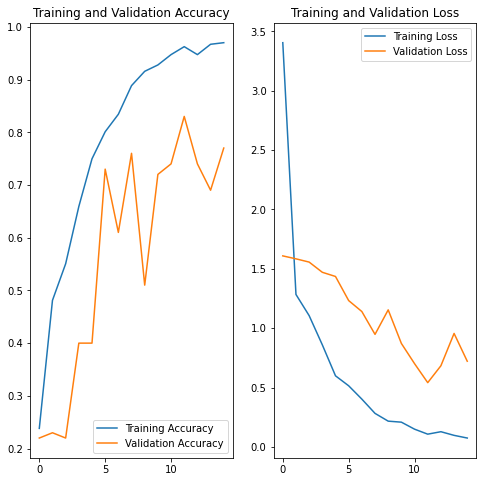

In [18]:
visualize_outputs(history_01, epoch=num_epochs)

#### Observations

- The model is able to achieve only 98% accuracy. The validation loss is ~90%. 
- The diff. is not huge. however the loss doesn't get a flatline.. 
- The model is trained for 15 epochs. We can try to increase the epochs count to check for better accuracy metrics.
- The model shows no signs of overfitting as the difference between the train and validation loss is very less.
- Total params: 3,856,069
Trainable params: 3,855,941
Non-trainable params: 128)

### Model-02:

- Increasig the epochs to 20
- Increasing the batch size from 20 -> 30
- Adjust the Learning Rate Factor to a smaller value... 

In [19]:
def prepare_conv3d_model_02():
    model = Sequential()
    model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))

    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.20))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [20]:
height = 120 # image width
width = 120 # image height

num_images = 20
batch_size = 30 #experiment with the batch size
img_idx = len(np.round(np.linspace(0,total_frames-1,num_images)).astype(int))

num_epochs = 20

LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.0001


In [21]:
curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [22]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 23
validation_steps 4


In [23]:
model_02 = prepare_conv3d_model_02()
optimizer = optimizers.adam_v2.Adam()
model_02.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_02.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_5 (Activation)   (None, 20, 120, 120, 32)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                                 
 activation_6 (Activation)   (None, 10, 60, 60, 64)    0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 5, 30, 30, 64)    0         
 3D)                                                  

In [24]:
training_data_gen = gesture_generator(TRAIN_DIR, train_doc, batch_size, img_idx, height, width)
validation_data_gen = gesture_generator(VAL_DIR, val_doc, batch_size, img_idx, height, width)

In [25]:
#fit_generator is deprecated.. using model.fit with generator objects...

history_02 = model_02.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.5640 - categorical_accuracy: 0.3499
Epoch 00001: val_loss improved from inf to 1.72209, saving model to MODELS/model_init_2023-10-0317_02_05.970829/model-00001-1.56404-0.34992-1.72209-0.25000.h5
23/23 [==============================] - 107s 5s/step - loss: 1.5640 - categorical_accuracy: 0.3499 - val_loss: 1.7221 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.1859 - categorical_accuracy: 0.4857
Epoch 00002: val_loss improved from 1.72209 to 1.50965, saving model to MODELS/model_init_2023-10-0317_02_05.970829/model-00002-1.18589-0.48567-1.50965-0.20000.h5
23/23 [==============================] - 106s 5s/step - loss: 1.1859 - categorical_accuracy: 0.4857 - val_loss: 1.5096 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.0969 - categorical_accuracy: 0.5370
Epoch 00003: val_loss impr

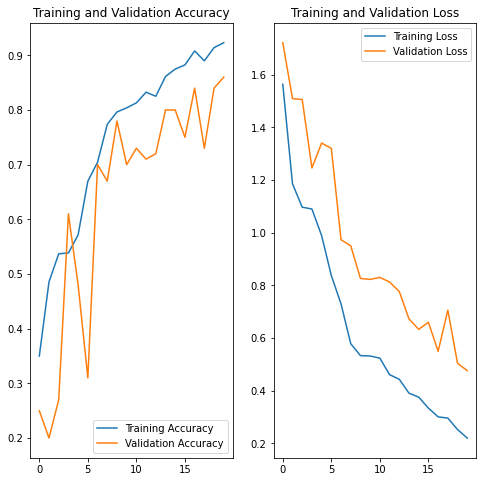

In [26]:
visualize_outputs(history_02, epoch=num_epochs)

### Observations

- The Loss graph is not stablized and also the there is no improvement in the accuracy. 
- Total params: 981,189 Trainable params: 980,933 Non-trainable params: 256

### MODEL-03

- Experiment with increasing the Dense layers.
- Adjust Learning Rate Plateau factor.

In [27]:
def prepare_conv3d_model_03():
    model = Sequential()
    model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))

    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.20))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [28]:
height = 120 # image width
width = 120 # image height

batch_size = 20 #experiment with the batch size
img_idx = len(np.round(np.linspace(0,total_frames-1,num_images)).astype(int))
num_epochs = 20

LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.0001


In [29]:
curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [30]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 34
validation_steps 5


In [31]:
model_03 = prepare_conv3d_model_03()
optimizer = optimizers.adam_v2.Adam()
model_03.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_03.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_12 (Activation)  (None, 20, 120, 120, 32)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                                 
 activation_13 (Activation)  (None, 10, 60, 60, 64)    0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 30, 30, 64)    0         
 3D)                                                  

In [32]:
training_data_gen = gesture_generator(TRAIN_DIR, train_doc, batch_size, img_idx, height, width)
validation_data_gen = gesture_generator(VAL_DIR, val_doc, batch_size, img_idx, height, width)

In [33]:
#fit_generator is deprecated.. using model.fit with generator objects...

history_03 = model_03.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6067 - categorical_accuracy: 0.1946
Epoch 00001: val_loss improved from inf to 1.45644, saving model to MODELS/model_init_2023-10-0317_37_58.704340/model-00001-1.60673-0.19457-1.45644-0.23000.h5
34/34 [==============================] - 108s 3s/step - loss: 1.6067 - categorical_accuracy: 0.1946 - val_loss: 1.4564 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4799 - categorical_accuracy: 0.3273
Epoch 00002: val_loss improved from 1.45644 to 1.19565, saving model to MODELS/model_init_2023-10-0317_37_58.704340/model-00002-1.47991-0.32730-1.19565-0.47000.h5
34/34 [==============================] - 109s 3s/step - loss: 1.4799 - categorical_accuracy: 0.3273 - val_loss: 1.1957 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3235 - categorical_accuracy: 0.3529
Epoch 00003: val_loss impr

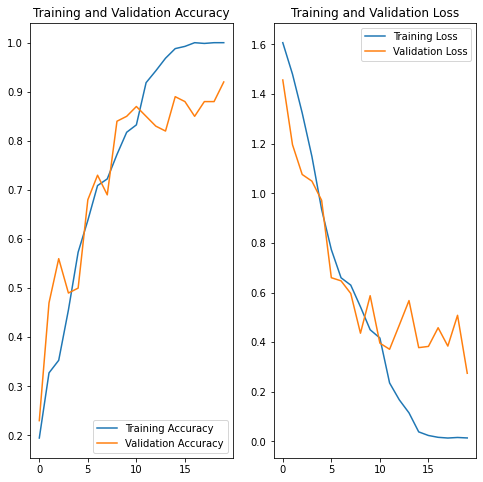

In [34]:
visualize_outputs(history_03, epoch=num_epochs)

### Model-04

- Experimenting the same model with a reduced image size to 100x100

In [35]:
height = 100 # image width
width = 100 # image height

batch_size = 20 #experiment with the batch size

num_epochs = 20
LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.0001


In [36]:
curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [37]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 34
validation_steps 5


In [38]:
model_04 = prepare_conv3d_model_03()
optimizer = optimizers.adam_v2.Adam()
model_04.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_04.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 20, 100, 100, 32)  2624      
                                                                 
 activation_19 (Activation)  (None, 20, 100, 100, 32)  0         
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 10, 50, 50, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 10, 50, 50, 64)    55360     
                                                                 
 activation_20 (Activation)  (None, 10, 50, 50, 64)    0         
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 5, 25, 25, 64)    0         
 g3D)                                                 

In [39]:
training_data_gen = gesture_generator(TRAIN_DIR, train_doc, batch_size, img_idx, height, width)
validation_data_gen = gesture_generator(VAL_DIR, val_doc, batch_size, img_idx, height, width)

In [40]:
#fit_generator is deprecated.. using model.fit with generator objects...

history_04 = model_04.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6279 - categorical_accuracy: 0.1991
Epoch 00001: val_loss improved from inf to 1.60819, saving model to MODELS/model_init_2023-10-0318_14_06.664254/model-00001-1.62791-0.19910-1.60819-0.22000.h5
34/34 [==============================] - 106s 3s/step - loss: 1.6279 - categorical_accuracy: 0.1991 - val_loss: 1.6082 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5799 - categorical_accuracy: 0.2157
Epoch 00002: val_loss did not improve from 1.60819
34/34 [==============================] - 106s 3s/step - loss: 1.5799 - categorical_accuracy: 0.2157 - val_loss: 2.3236 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.6401 - categorical_accuracy: 0.2308
Epoch 00003: val_loss improved from 1.60819 to 1.55372, saving model to MODELS/model_init_2023-10-0318_14_06.664254/model-00003-1.64006-0.

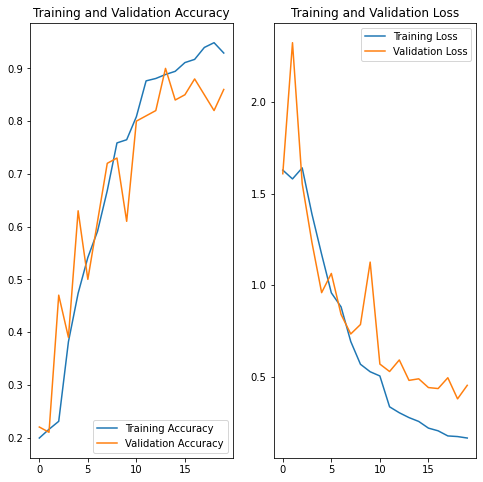

In [41]:
visualize_outputs(history_04, epoch=num_epochs)

#### Observations

- No improvement in the accuracy levels. 
- Loss has also increased. No improvement in reducing the image size. 
- Total params: 1,169,093 Trainable params: 1,169,093

### Model-05
- The problem is to identify the gesture and has no relation with the colors of the image. Hence, trying out to grayscale the image so as to reduce the layers and parameters. 

In [42]:
def prepare_conv3d_grayscale_model_05(num_classes, color_channels = 3):
    model = Sequential()
    model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(num_images, height, width, color_channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 2), padding='same'))

    model.add(Conv3D(256, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.20))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [43]:
height = 120 # image width
width = 120 # image height

batch_size = 30 #experiment with the batch size

num_epochs = 20
LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.2
LrPlateau_fmin_lr = 0.0001


In [44]:

curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)


In [45]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 23
validation_steps 4


In [46]:
model_05 = prepare_conv3d_grayscale_model_05(num_classes, 1)
optimizer = optimizers.adam_v2.Adam()
model_05.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_05.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 20, 120, 120, 32)  896       
                                                                 
 activation_26 (Activation)  (None, 20, 120, 120, 32)  0         
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 activation_27 (Activation)  (None, 10, 60, 60, 64)    0         
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 5, 30, 30, 64)    0         
 g3D)                                                 

In [47]:
training_data_gen = gesture_generator(TRAIN_DIR, train_doc, batch_size, img_idx, height, width, channels=1)
validation_data_gen = gesture_generator(VAL_DIR, val_doc, batch_size, img_idx, height, width, channels=1)

In [48]:
#fit_generator is deprecated.. using model.fit with generator objects...
history_05 = model_05.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 6.5901 - categorical_accuracy: 0.1840
Epoch 00001: val_loss improved from inf to 1.58855, saving model to MODELS/model_init_2023-10-0318_49_18.444946/model-00001-6.59010-0.18401-1.58855-0.22000.h5
23/23 [==============================] - 102s 5s/step - loss: 6.5901 - categorical_accuracy: 0.1840 - val_loss: 1.5885 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.6056 - categorical_accuracy: 0.1916
Epoch 00002: val_loss did not improve from 1.58855
23/23 [==============================] - 102s 5s/step - loss: 1.6056 - categorical_accuracy: 0.1916 - val_loss: 1.5946 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.5578 - categorical_accuracy: 0.2353
Epoch 00003: val_loss improved from 1.58855 to 1.38736, saving model to MODELS/model_init_2023-10-0318_49_18.444946/model-00003-1.55784-0.

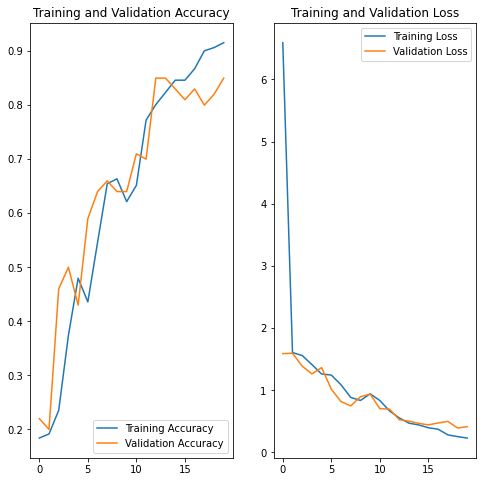

In [49]:
visualize_outputs(history_05, epoch=num_epochs)

### MODEL 6
- With Reduced Batch Size

In [68]:
height = 120 # image width
width = 120 # image height

batch_size = 10 #experiment with the batch size
img_idx = len(np.round(np.linspace(0,total_frames-1,num_images)).astype(int)) #create a list of image numbers you want to use for a particular video
num_epochs = 20
LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.2
LrPlateau_fmin_lr = 0.1


In [69]:

curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)


In [70]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 67
validation_steps 10


In [71]:
training_data_gen = gesture_generator(TRAIN_DIR, train_doc, batch_size, img_idx, height, width, channels=1)
validation_data_gen = gesture_generator(VAL_DIR, val_doc, batch_size, img_idx, height, width, channels=1)

In [72]:
model_06 = prepare_conv3d_grayscale_model_05(num_classes, 1)
optimizer = optimizers.adam_v2.Adam()
model_06.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_06.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_38 (Conv3D)          (None, 20, 120, 120, 32)  896       
                                                                 
 activation_54 (Activation)  (None, 20, 120, 120, 32)  0         
                                                                 
 max_pooling3d_38 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_39 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 activation_55 (Activation)  (None, 10, 60, 60, 64)    0         
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 5, 30, 30, 64)    0         
 g3D)                                                 

In [73]:
#fit_generator is deprecated.. using model.fit with generator objects...
history_06 = model_06.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 3.0135 - categorical_accuracy: 0.2413
Epoch 00001: val_loss improved from inf to 1.65798, saving model to MODELS/model_init_2023-10-0319_29_14.465116/model-00001-3.01349-0.24133-1.65798-0.28000.h5
67/67 [==============================] - 101s 2s/step - loss: 3.0135 - categorical_accuracy: 0.2413 - val_loss: 1.6580 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.4902 - categorical_accuracy: 0.3303
Epoch 00002: val_loss improved from 1.65798 to 1.30244, saving model to MODELS/model_init_2023-10-0319_29_14.465116/model-00002-1.49019-0.33032-1.30244-0.44000.h5
67/67 [==============================] - 100s 2s/step - loss: 1.4902 - categorical_accuracy: 0.3303 - val_loss: 1.3024 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.2697 - categorical_accuracy: 0.4329
Epoch 00003: val_loss impr

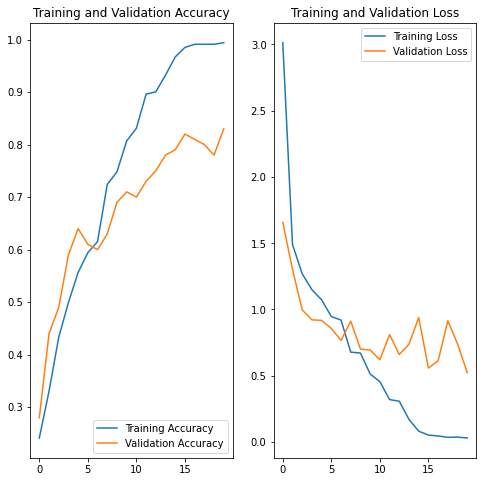

In [74]:
visualize_outputs(history_06, epoch=num_epochs)

#### Model 7 - CNN-RNN

- Using Time Distributed CNN Layers, whose output is forwarded to a RNN layer (LSTM)

In [75]:
 def process_cnn_batch_data(source_path, t, batch, batch_size, num_frames, img_idx, height, width, channels=3, remaining_seq=0):
    seq_len = remaining_seq if remaining_seq else batch_size
    batch_data = np.zeros((seq_len, num_frames, height, width, channels))
    batch_labels = np.zeros((seq_len, num_classes))

    for folder in range(seq_len):
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
        for idx,item in enumerate(img_idx):
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image_resized=resize(image,(height, width, channels))

            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
            batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
            batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return(batch_data,batch_labels)

In [76]:
def cnn_generator(source_path, folder_list, batch_size, num_frames, img_idx, height, width, channels=1):
    #img_idx = np.round(np.linspace(0,total_frames-1,self.frames_to_sample)).astype(int)

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size

        for batch in range(num_batches):
            batch_data, batch_labels= process_cnn_batch_data(source_path, t, batch, batch_size, num_frames, img_idx, height, width, channels)
            yield batch_data, batch_labels

        remaining_seq=len(t)%batch_size

        if (remaining_seq != 0):
            batch_data, batch_labels= process_cnn_batch_data(source_path, t, num_batches, batch_size, num_frames, img_idx, height, width, channels, remaining_seq = remaining_seq)
            yield batch_data, batch_labels

In [77]:
def get_rnn_cnn_model(num_classes, num_frames, height, width, channels):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                              input_shape=(num_frames, height, width, channels)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(keras.layers.LSTM(64))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))
    return model

In [78]:
height = 120 # image width
width = 120 # image height

num_images = 20
batch_size = 30 #experiment with the batch size
img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int)

num_epochs = 20

LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.0001
channels = 3

In [79]:
IMG_SHAPE = (height, width, channels)

In [80]:
curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [81]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 23
validation_steps 4


In [82]:
model_07 = get_rnn_cnn_model(num_classes, num_images, height, width, channels)

In [83]:
optimizer = optimizers.adam_v2.Adam()

#optimizer = optimizers.Adam()
model_07.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_07.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 60, 60, 32)  

In [84]:
training_data_gen = cnn_generator(TRAIN_DIR, train_doc, batch_size, num_images, img_idx, height, width, channels=3)
validation_data_gen = cnn_generator(VAL_DIR, val_doc, batch_size, num_images, img_idx, height, width, channels=3)

In [85]:
#fit_generator is deprecated.. using model.fit with generator objects...
history_07 = model_07.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                               callbacks=callbacks_list, validation_data=validation_data_gen,
                               validation_steps=validation_steps)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.5010 - categorical_accuracy: 0.3379
Epoch 00001: val_loss improved from inf to 1.62176, saving model to MODELS/model_init_2023-10-0320_02_36.988986/model-00001-1.50104-0.33786-1.62176-0.29000.h5
23/23 [==============================] - 108s 5s/step - loss: 1.5010 - categorical_accuracy: 0.3379 - val_loss: 1.6218 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.2386 - categorical_accuracy: 0.5143
Epoch 00002: val_loss improved from 1.62176 to 1.58462, saving model to MODELS/model_init_2023-10-0320_02_36.988986/model-00002-1.23863-0.51433-1.58462-0.24000.h5
23/23 [==============================] - 107s 5s/step - loss: 1.2386 - categorical_accuracy: 0.5143 - val_loss: 1.5846 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.9685 - categorical_accuracy: 0.6742
Epoch 00003: val_loss did 

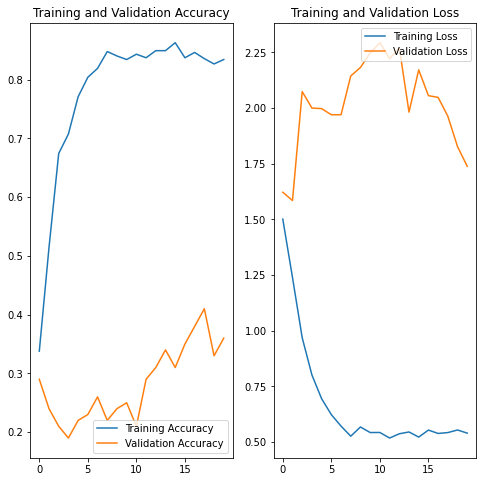

In [86]:
visualize_outputs(history_07, epoch=num_epochs)

#### MODEL-8 - GRU

In [87]:
def get_rnn_cnn_model_gru(num_classes, num_frames, height, width, channels):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                              input_shape=(num_frames, height, width, channels)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(keras.layers.GRU(64))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))
    return model

In [88]:
height = 120 # image width
width = 120 # image height

num_images = 20
batch_size = 30 #experiment with the batch size
img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int)

num_epochs = 20

LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.0001
channels = 3

IMG_SHAPE = (height, width, channels)

In [89]:
curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [90]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 23
validation_steps 4


In [91]:
model_08 = get_rnn_cnn_model_gru(num_classes, num_images, height, width, channels)

In [92]:
optimizer = optimizers.adam_v2.Adam()
#optimizer = optimizers.Adam()
model_08.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_08.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 60, 60, 32) 

In [93]:
training_data_gen = cnn_generator(TRAIN_DIR, train_doc, batch_size, num_images, img_idx, height, width, channels=3)
validation_data_gen = cnn_generator(VAL_DIR, val_doc, batch_size, num_images, img_idx, height, width, channels=3)

In [94]:
#fit_generator is deprecated.. using model.fit with generator objects...
history_08 = model_08.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                                   callbacks=callbacks_list, validation_data=validation_data_gen,
                                   validation_steps=validation_steps)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.3861 - categorical_accuracy: 0.4238
Epoch 00001: val_loss improved from inf to 1.81395, saving model to MODELS/model_init_2023-10-0320_37_57.778267/model-00001-1.38612-0.42383-1.81395-0.21000.h5
23/23 [==============================] - 111s 5s/step - loss: 1.3861 - categorical_accuracy: 0.4238 - val_loss: 1.8139 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.0591 - categorical_accuracy: 0.5837
Epoch 00002: val_loss did not improve from 1.81395
23/23 [==============================] - 106s 5s/step - loss: 1.0591 - categorical_accuracy: 0.5837 - val_loss: 1.9043 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.8946 - categorical_accuracy: 0.6440
Epoch 00003: val_loss did not improve from 1.81395

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
23/23

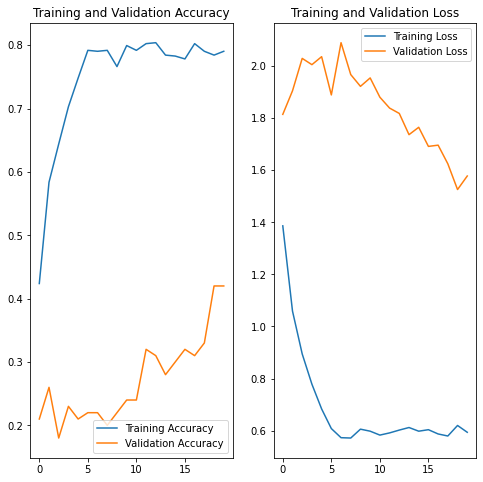

In [95]:
visualize_outputs(history_08, epoch=num_epochs)

#### MODEL 09- CNN-RNN - Transfer Learning (Mobilenet)

In [96]:
def get_lstm_model_with_transfer_learning(cnn_model, num_classes, num_images, height, width, channels):
    model = Sequential()
    model.add(TimeDistributed(cnn_model, input_shape=(num_images, height, width, channels)))

    for each_layer in model.layers:
        each_layer.trainable = False

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2,2))))
    model.add(TimeDistributed(Flatten()))

    model.add(keras.layers.LSTM(128))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))

    return model

In [97]:
height = 120 # image width
width = 120 # image height

num_images = 20
batch_size = 30 #experiment with the batch size
img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int)

num_epochs = 20

LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.0001
channels = 3

IMG_SHAPE = (height, width, channels)

In [98]:
curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [99]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 23
validation_steps 4


In [100]:
mobilenet_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False)

In [101]:
model_09 = get_lstm_model_with_transfer_learning(mobilenet_model, num_classes, num_images, height, width, channels)

In [102]:
optimizer = optimizers.adam_v2.Adam()
#optimizer = optimizers.Adam()
model_09.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_09.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)             

In [103]:
training_data_gen = cnn_generator(TRAIN_DIR, train_doc, batch_size, num_images, img_idx, height, width, channels=3)
validation_data_gen = cnn_generator(VAL_DIR, val_doc, batch_size, num_images, img_idx, height, width, channels=3)

In [104]:
#fit_generator is deprecated.. using model.fit with generator objects...
history_09 = model_09.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                          callbacks=callbacks_list, validation_data=validation_data_gen,
                          validation_steps=validation_steps)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.2720 - categorical_accuracy: 0.4887
Epoch 00001: val_loss improved from inf to 1.01681, saving model to MODELS/model_init_2023-10-0321_13_18.931292/model-00001-1.27205-0.48869-1.01681-0.65000.h5
23/23 [==============================] - 111s 5s/step - loss: 1.2720 - categorical_accuracy: 0.4887 - val_loss: 1.0168 - val_categorical_accuracy: 0.6500 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.4722 - categorical_accuracy: 0.8778
Epoch 00002: val_loss improved from 1.01681 to 0.69667, saving model to MODELS/model_init_2023-10-0321_13_18.931292/model-00002-0.47218-0.87783-0.69667-0.76000.h5
23/23 [==============================] - 106s 5s/step - loss: 0.4722 - categorical_accuracy: 0.8778 - val_loss: 0.6967 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.2109 - categorical_accuracy: 0.9623
Epoch 00003: val_loss impr

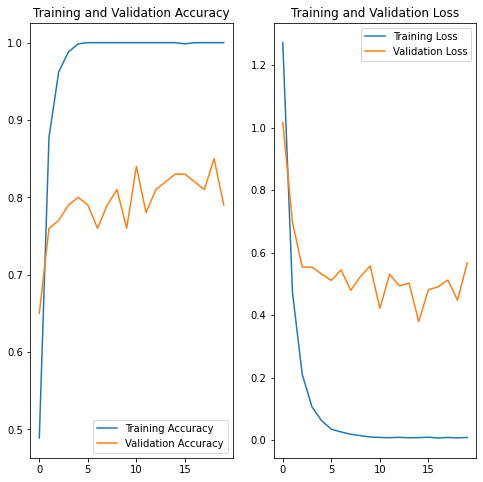

In [105]:
visualize_outputs(history_09, epoch=num_epochs)

#### Model-10 - CNN-RNN(GRU)

In [106]:
def get_gru_model_with_transfer_learning(cnn_model, num_classes, num_images, height, width, channels):
    model = Sequential()
    model.add(TimeDistributed(cnn_model, input_shape=(num_images, height, width, channels)))

    for each_layer in model.layers:
        each_layer.trainable = False

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2,2))))
    model.add(TimeDistributed(Flatten()))

    model.add(keras.layers.GRU(128, recurrent_dropout=0.15))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))

    return model

In [107]:
model_10 = get_gru_model_with_transfer_learning(mobilenet_model, num_classes, num_images, height, width, channels)

In [108]:
optimizer = optimizers.adam_v2.Adam()
#optimizer = optimizers.Adam()
model_10.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_10.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)             

In [109]:
training_data_gen = cnn_generator(TRAIN_DIR, train_doc, batch_size, num_images, img_idx, height, width, channels=3)
validation_data_gen = cnn_generator(VAL_DIR, val_doc, batch_size, num_images, img_idx, height, width, channels=3)

In [110]:
#fit_generator is deprecated.. using model.fit with generator objects...
history_10 = model_10.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                          callbacks=callbacks_list, validation_data=validation_data_gen,
                          validation_steps=validation_steps)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.2911 - categorical_accuracy: 0.4992
Epoch 00001: val_loss did not improve from 0.37927
23/23 [==============================] - 110s 5s/step - loss: 1.2911 - categorical_accuracy: 0.4992 - val_loss: 0.8128 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.3621 - categorical_accuracy: 0.8959
Epoch 00002: val_loss did not improve from 0.37927
23/23 [==============================] - 107s 5s/step - loss: 0.3621 - categorical_accuracy: 0.8959 - val_loss: 0.7457 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.1739 - categorical_accuracy: 0.9623
Epoch 00003: val_loss did not improve from 0.37927
23/23 [==============================] - 107s 5s/step - loss: 0.1739 - categorical_accuracy: 0.9623 - val_loss: 0.5778 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 4/20
23/23 [==========

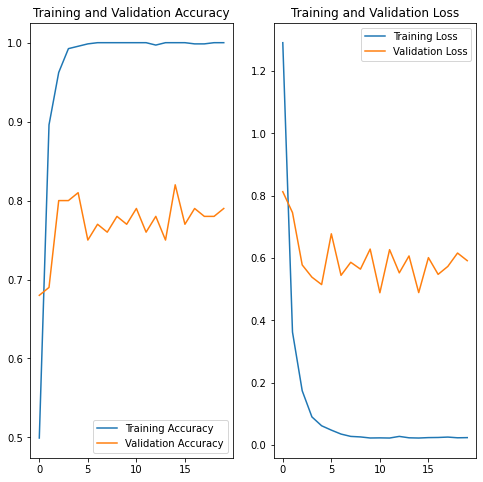

In [111]:
visualize_outputs(history_10, epoch=num_epochs)